In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.transforms as T
import xml.etree.ElementTree as ET

class CustomDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "annotations"))))

        # Ensure each image has a corresponding annotation file
        self.imgs = [img for img in self.imgs if img.replace('.jpg', '.xml') in self.boxes]
        self.boxes = [box for box in self.boxes if box.replace('.xml', '.jpg') in self.imgs]

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        box_path = os.path.join(self.root, "annotations", self.boxes[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(box_path)
        root = tree.getroot()

        boxes = []
        for obj in root.findall('object'):
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            ymin = int(xmlbox.find('ymin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymax = int(xmlbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": image_id, "area": area, "iscrowd": iscrowd}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# Load a pre-trained model for common objects detection
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Dataset and DataLoader
train_dataset = CustomDataset('/content/drive/MyDrive/train', get_transform())
test_dataset = CustomDataset('/content/drive/MyDrive/test', get_transform())
data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
data_loader_test = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Training and evaluation functions
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch} Loss: {losses.item()}")

def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images, targets)
            # Perform evaluation, e.g., using a metric like mAP (Mean Average Precision)

# Set up device, model, optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # 1 class (object) + background
model = get_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    evaluate(model, data_loader_test, device)

print("Training completed.")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. Yo

Epoch 0 Loss: 0.1371108442544937
Epoch 1 Loss: 0.0685751661658287
Epoch 2 Loss: 0.055983562022447586
Epoch 3 Loss: 0.04266032576560974
Epoch 4 Loss: 0.03685152530670166
Epoch 5 Loss: 0.028749218210577965
Epoch 6 Loss: 0.023214686661958694
Epoch 7 Loss: 0.03637056052684784
Epoch 8 Loss: 0.018878238275647163
Epoch 9 Loss: 0.02637074887752533
Training completed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


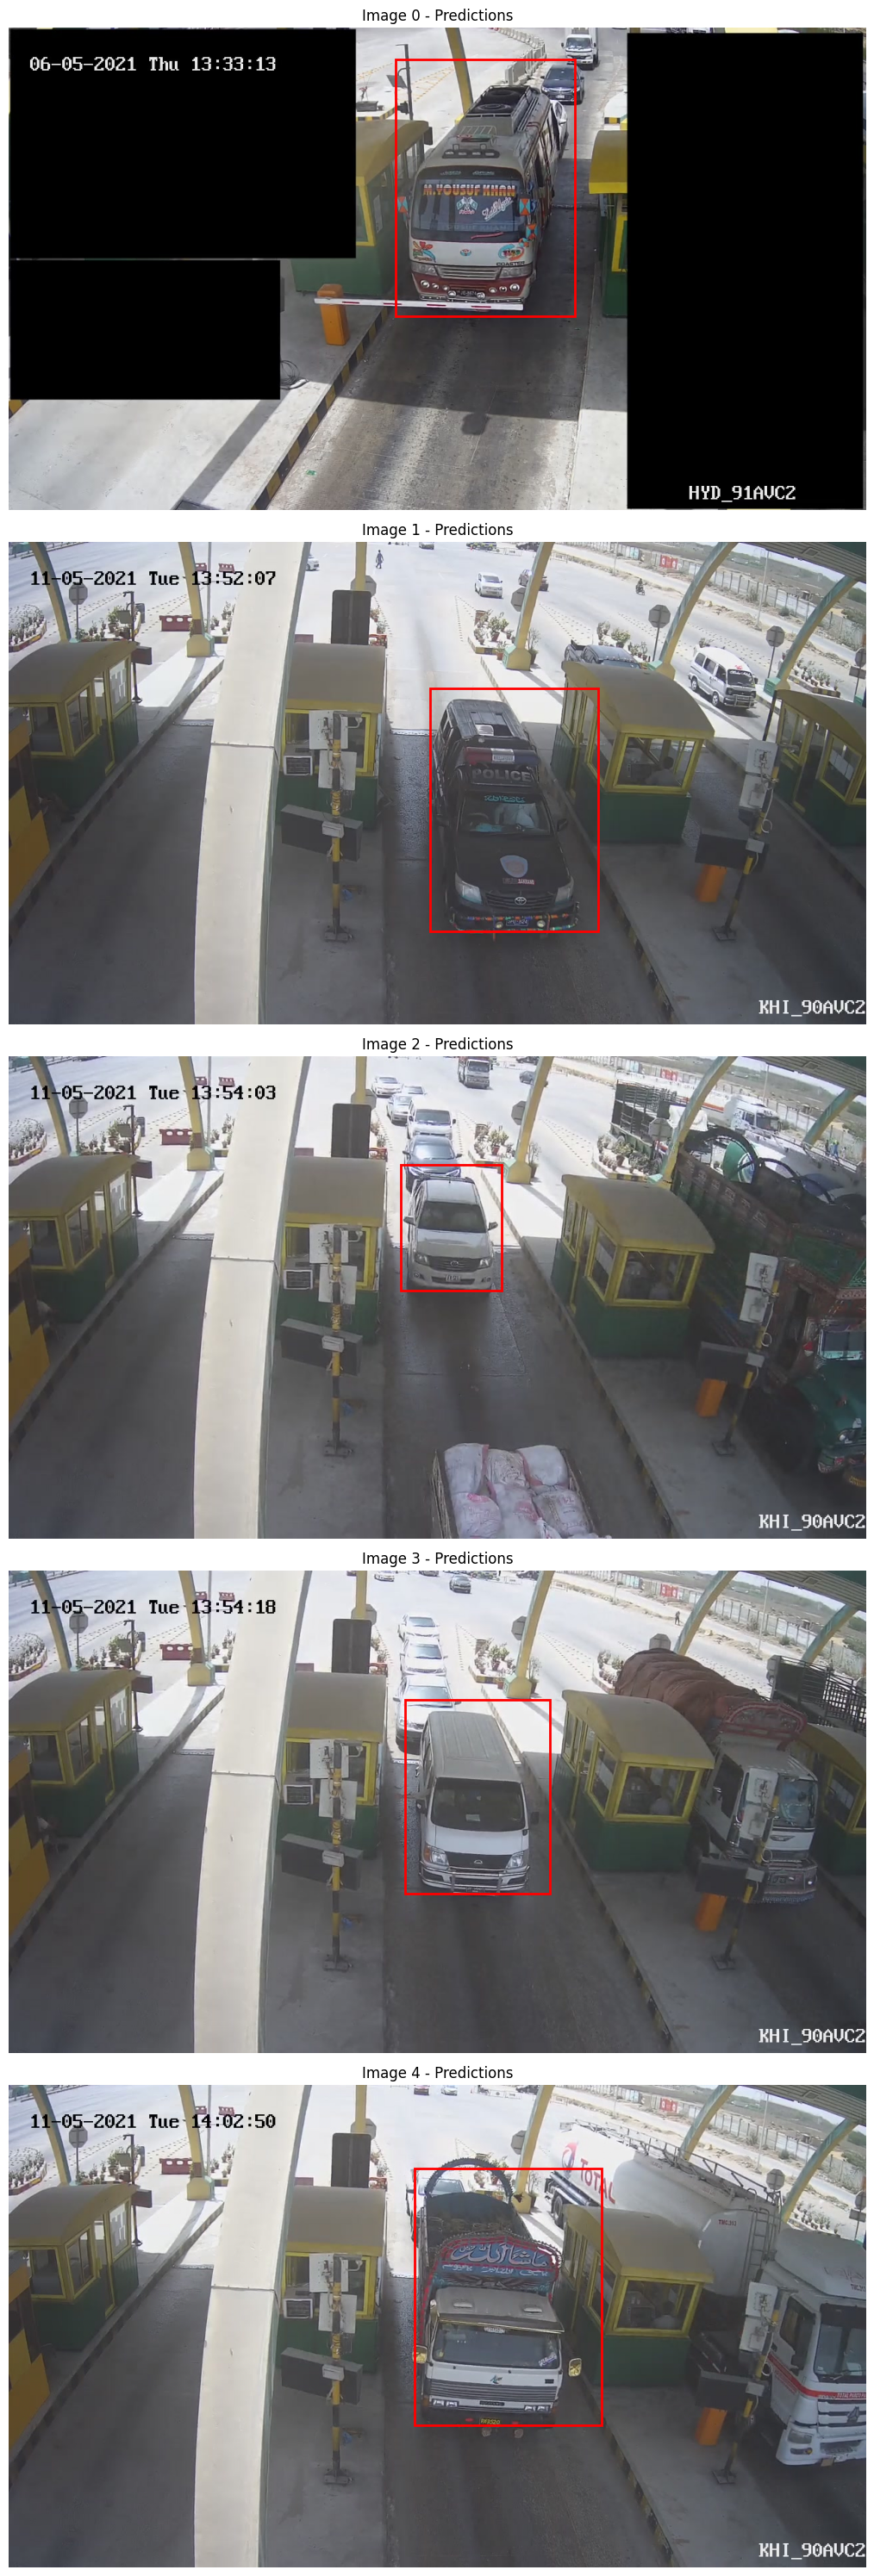

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, device, num_images=5):
    model.eval()
    fig, ax = plt.subplots(num_images, 1, figsize=(12, num_images * 6))
    ax = ax.flatten()

    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            if i >= num_images:
                break
            images = list(image.to(device) for image in images)
            outputs = model(images)

            img = images[0].cpu().permute(1, 2, 0).numpy()
            ax[i].imshow(img)

            for box in outputs[0]['boxes']:
                xmin, ymin, xmax, ymax = box.cpu()
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
                ax[i].add_patch(rect)

            ax[i].set_title(f"Image {i} - Predictions")
            ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on test dataset
visualize_predictions(model, data_loader_test, device)


['avc2 1281.jpg', 'KhiAVC2 1337.jpg', 'avc2 1181.jpg', 'avc2 1197.jpg', 'avc2 1114.jpg', 'KhiAVC2 1995.jpg', 'KhiAVC2 3255.jpg', 'avc2 1075.jpg', 'avc2 1152.jpg', 'KhiAVC2 3038.jpg', 'KhiAVC2 3265.jpg', 'KhiAVC2 2648.jpg', 'KhiAVC2 1864.jpg', 'avc2 1259.jpg', 'KhiAVC2 3097.jpg', 'KhiAVC2 1221.jpg', 'avc2 1189.jpg', 'KhiAVC2 2579.jpg', 'AVCHamza2 3339.jpg', 'KhiAVC2 3260.jpg', 'avc2 1283.jpg', 'KhiAVC2 1352.jpg', 'KhiAVC2 3273.jpg', 'avc2 1068.jpg', 'KhiAVC2 2675.jpg', 'avc2 1248.jpg', 'KhiAVC2 3277.jpg', 'KhiAVC2 2679.jpg', 'KhiAVC2 3268.jpg', 'KhiAVC2 3282.jpg', 'KhiAVC2 2004.jpg', 'KhiAVC2 3285.jpg', 'KhiAVC2 3278.jpg', 'KhiAVC2 3270.jpg', 'KhiAVC2 3266.jpg', 'KhiAVC2 3263.jpg', 'KhiAVC2 3102.jpg', 'KhiAVC2 3275.jpg', 'KhiAVC2 3272.jpg', 'KhiAVC2 3274.jpg', 'KhiAVC2 3284.jpg', 'KhiAVC2 3261.jpg', 'KhiAVC2 3286.jpg', 'KhiAVC2 2605.jpg', 'KhiAVC2 3267.jpg', 'KhiAVC2 3287.jpg', 'KhiAVC2 3271.jpg', 'avc2 1272.jpg', 'KhiAVC2 3288.jpg', 'KhiAVC2 2015.jpg', 'KhiAVC2 2485.jpg', 'KhiAVC2 3280

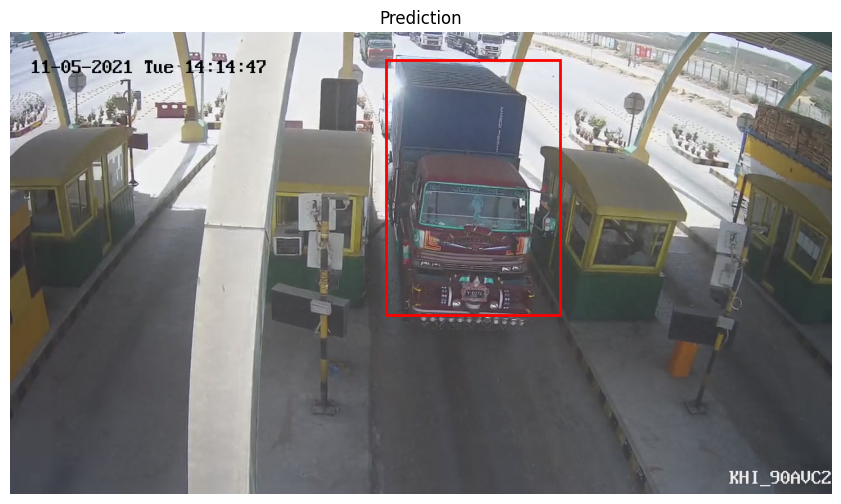

In [ ]:
import os
import matplotlib.pyplot as plt

def list_test_images(test_image_dir):
    test_images = os.listdir(test_image_dir)
    print(test_images)
    return test_images

def predict(model, img_path, device):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    transform = get_transform()
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img)

    return prediction

def visualize_single_prediction(img_path, prediction):
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(12, 6))
    plt.imshow(img)

    for box in prediction[0]['boxes']:
        xmin, ymin, xmax, ymax = box.cpu()
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)

    plt.title("Prediction")
    plt.axis('off')
    plt.show()

# List files in test image directory
test_image_dir = "/content/drive/MyDrive/test/images"
test_images = list_test_images(test_image_dir)

# Example usage with a specific image file from the test directory
new_image_path = os.path.join(test_image_dir, test_images[17])  # Using the first image from the list
prediction = predict(model, new_image_path, device)

# Visualize the prediction
visualize_single_prediction(new_image_path, prediction)


In [ ]:
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import xml.etree.ElementTree as ET

# Load pre-trained VGG16 model + higher level layers
vgg16 = models.vgg16(pretrained=True).features
vgg16.eval()

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(img_path, model):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = model(img_t)
    return features.view(-1).cpu().numpy()  # Flatten features

def get_label_from_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    label = root.find('object').find('name').text
    return label

def process_dataset(image_dir, annotation_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for img_file in os.listdir(image_dir):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(image_dir, img_file)
            xml_file = img_file.replace('.jpg', '.xml')
            xml_path = os.path.join(annotation_dir, xml_file)

            if os.path.exists(xml_path):
                # Extract features
                features = extract_features(img_path, vgg16)
                label = get_label_from_xml(xml_path)

                # Save features
                output_path = os.path.join(output_dir, img_file.replace('.jpg', '.npy'))
                np.save(output_path, {'features': features, 'label': label})
            else:
                print(f"XML file not found for {img_path}")

# Define directories
train_image_dir = '/content/drive/MyDrive/train/images'
train_annotation_dir = '/content/drive/MyDrive/train/annotations'
train_output_dir = '/content/drive/MyDrive/train_features'

test_image_dir = '/content/drive/MyDrive/test/images'
test_annotation_dir = '/content/drive/MyDrive/test/annotations'
test_output_dir = '/content/drive/MyDrive/test_features'

# Process train and test datasets
process_dataset(train_image_dir, train_annotation_dir, train_output_dir)
process_dataset(test_image_dir, test_annotation_dir, test_output_dir)

print("Feature extraction process complete.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extraction process complete.


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for loading features and labels
class FeatureDataset(Dataset):
    def __init__(self, feature_dir, label_map):
        self.feature_files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.npy')]
        self.label_map = label_map

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        data = np.load(self.feature_files[idx], allow_pickle=True).item()
        features = data['features']
        label = self.label_map[data['label']]  # Map string label to integer
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Mapping from string labels to integer labels
label_map = {
    'Medium size Vehicle': 0,
    'Heavy Vehicle': 1
}

# Directories where features are saved
train_feature_dir = '/content/drive/MyDrive/train_features'
test_feature_dir = '/content/drive/MyDrive/test_features'

# Create datasets and dataloaders
train_dataset = FeatureDataset(train_feature_dir, label_map)
test_dataset = FeatureDataset(test_feature_dir, label_map)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Feature datasets and dataloaders are created.")



Feature datasets and dataloaders are created.


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class FeatureDataset(Dataset):
    def __init__(self, feature_dir, label_map):
        self.feature_files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.npy')]
        self.label_map = label_map

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        data = np.load(self.feature_files[idx], allow_pickle=True).item()
        features = data['features']
        label = self.label_map[data['label']]  # Map string label to integer
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = FeatureDataset(train_feature_dir, label_map)
test_dataset = FeatureDataset(test_feature_dir, label_map)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Feature datasets and dataloaders are created.")


Feature datasets and dataloaders are created.


In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

def extract_and_save_features(image_dir, annotation_dir, feature_dir, model, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    if not os.path.exists(feature_dir):
        os.makedirs(feature_dir)

    model.eval()

    for image_name in os.listdir(image_dir):
        if image_name.endswith(".jpg"):
            image_path = os.path.join(image_dir, image_name)
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                features = model(image_tensor)
                features = features.view(features.size(0), -1)  # Flatten features

                feature_file = os.path.join(feature_dir, f"{os.path.splitext(image_name)[0]}.npy")
                np.save(feature_file, features.cpu().numpy())

# Assuming you have a pre-trained VGG16 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = models.vgg16(pretrained=True).features.to(device)

train_image_dir = '/content/drive/MyDrive/train/images'
train_feature_dir = '/contant/drive/MyDrive/train/features'
extract_and_save_features(train_image_dir, None, train_feature_dir, vgg16, device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# After training the classifier
torch.save(model.state_dict(), 'classifier.pth')  # Save the model to the current directory


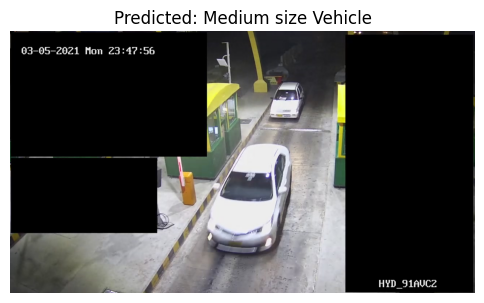

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assume the classifier is already trained
num_classes = 2
input_size = 25088  # Size of the flattened VGG16 features
model = Classifier(input_size, num_classes)
model.load_state_dict(torch.load('classifier.pth'))  # Replace with the correct path
model.to(device)

# Prediction and visualization function
def predict_and_visualize(image_path, vgg16, classifier, label_map, transform):
    classifier.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Extract features using VGG16
    vgg16.eval()
    with torch.no_grad():
        features = vgg16(image_tensor)
        features = features.view(features.size(0), -1)  # Flatten features

    # Classify the features
    with torch.no_grad():
        output = classifier(features)
        _, predicted = torch.max(output.data, 1)

    # Convert predicted label to class name
    class_names = list(label_map.keys())
    predicted_label = class_names[predicted.item()]

    # Display the image and prediction
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/test/images/KhiAVC2 3265.jpg'  # Replace with the path to your image
predict_and_visualize(image_path, vgg16, model, label_map, transform)


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
import torch.nn as nn
import torchvision.models as models

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

model = Classifier(num_classes=2)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Epoch [1/10], Loss: 1.895412027835846
Epoch [2/10], Loss: 1.4461410194635391
Epoch [3/10], Loss: 0.32833532243967056
Epoch [4/10], Loss: 0.05573177803307772
Epoch [5/10], Loss: 0.07481057732366025
Epoch [6/10], Loss: 0.048537673661485314
Epoch [7/10], Loss: 0.0019403730912017636
Epoch [8/10], Loss: 0.00010789594307425432
Epoch [9/10], Loss: 0.00010899799599428661
Epoch [10/10], Loss: 0.00011479992463137023
Training complete.


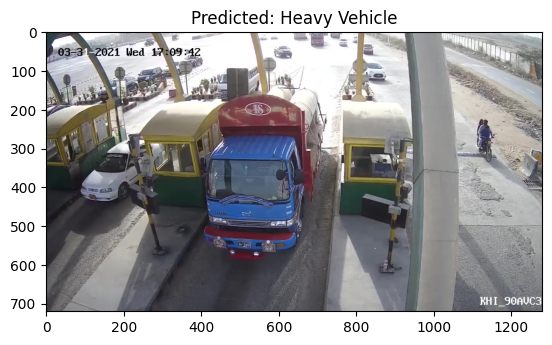

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
feature_extractor = nn.Sequential(*list(vgg16.features.children())).to(device)

# Define the Classifier model
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = 512 * 7 * 7  # Size of the flattened features from VGG16
num_classes = len(label_map)  # Ensure this matches the number of classes
model = Classifier(input_size, num_classes).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

print("Training complete.")

# Prediction and Visualization
def extract_features(input_tensor, feature_extractor):
    with torch.no_grad():
        features = feature_extractor(input_tensor)
        features = features.view(features.size(0), -1)  # Flatten the features
    return features

def predict_and_visualize(image_path, model, label_map, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        # Forward pass through the feature extractor
        features = extract_features(input_tensor, feature_extractor)
        # Forward pass through the classifier
        output = model(features)
        _, predicted = torch.max(output, 1)
        predicted_label = [k for k, v in label_map.items() if v == predicted.item()][0]

    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/train/images/AVC10922.jpg'  # Replace with the path to your image
predict_and_visualize(image_path, model, label_map, transform)


In [ ]:
# Define the dataset and dataloader for the test set (assuming the test set is similar to the train set)
class FeatureDataset(Dataset):
    def __init__(self, feature_dir, label_map):
        self.feature_files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.npy')]
        self.label_map = label_map

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        data = np.load(self.feature_files[idx], allow_pickle=True).item()
        features = data['features']
        label = self.label_map[data['label']]  # Map string label to integer
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

test_feature_dir = '/content/drive/MyDrive/test_features'  # Replace with your test feature directory
test_dataset = FeatureDataset(test_feature_dir, label_map)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to evaluate model accuracy
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on the test set
accuracy = evaluate_model(model, test_loader, device)
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Accuracy of the model on the test set: 59.68%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your custom classifier
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Assuming your input_size and num_classes are already defined
input_size = 7 * 7 * 512  # Size of the flattened feature map from VGG16
num_classes = 3  # Example: heavy, medium, light

# Initialize model, loss function, and optimizer
model = Classifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Example training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Save the trained model
torch.save(model.state_dict(), 'trained_classifier.pth')
print("Model saved successfully.")


Epoch 1, Loss: 0.909887433052063
Epoch 2, Loss: 1.185769408941269
Epoch 3, Loss: 0.7604601681232452
Epoch 4, Loss: 0.5076799094676971
Epoch 5, Loss: 0.4068964496254921
Epoch 6, Loss: 0.19205155852250755
Epoch 7, Loss: 0.43911926448345184
Epoch 8, Loss: 0.16884637996554375
Epoch 9, Loss: 0.03507258502941113
Epoch 10, Loss: 0.08330699056386948
Model saved successfully.


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

class AugmentedFeatureDataset(Dataset):
    def __init__(self, feature_dir, label_map, transform=None):
        self.feature_files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.npy')]
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        data = np.load(self.feature_files[idx], allow_pickle=True).item()
        features = data['features']
        label_str = data['label']

        if label_str not in self.label_map:
            raise ValueError(f"Label '{label_str}' not found in label_map")

        label = self.label_map[label_str]

        # Convert numpy array to PIL image if it's image-like
        features = Image.fromarray(features) if isinstance(features, np.ndarray) else features

        if self.transform:
            features = self.transform(features)

        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
import numpy as np

class AugmentedFeatureDataset(Dataset):
    def __init__(self, feature_dir, label_map, transform=None):
        self.feature_files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.npy')]
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        data = np.load(self.feature_files[idx], allow_pickle=True).item()
        features = data['features']
        label_str = data['label']

        if label_str not in self.label_map:
            raise ValueError(f"Label '{label_str}' not found in label_map")

        label = self.label_map[label_str]

        # Apply numpy-based transformations if needed
        if self.transform:
            features = self.transform(features)

        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Define numpy-based augmentation (example: add noise)
def numpy_transform(features):
    noise = np.random.normal(0, 0.1, features.shape)
    return features + noise

transform = numpy_transform  # Replace with your numpy-based transformation

# Initialize dataset and dataloader for the test set
test_feature_dir = '/content/drive/MyDrive/test_features'  # Replace with your test feature directory
augmented_test_dataset = AugmentedFeatureDataset(test_feature_dir, label_map, transform=transform)
augmented_test_loader = DataLoader(augmented_test_dataset, batch_size=32, shuffle=False)


In [ ]:
sample_idx = 0
sample_data = augmented_test_dataset[sample_idx]
features, label = sample_data
print("Label:", label)
print("Augmented Features Sample:", features)


Label: tensor(0)
Augmented Features Sample: tensor([ 0.0117, -0.0166,  0.0284,  ...,  0.0819,  0.0629,  1.2670])


In [ ]:
class AugmentedFeatureDataset(Dataset):
    def __init__(self, feature_dir, label_map, transform=None):
        self.feature_files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.npy')]
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        data = np.load(self.feature_files[idx], allow_pickle=True).item()
        features = data['features']
        label_str = data['label']

        # Convert numpy array to PIL image if it's image-like
        if isinstance(features, np.ndarray):
            features = Image.fromarray(features)
            if features.mode != 'RGB':  # Ensure the image is in RGB mode
                features = features.convert('RGB')

        if self.transform:
            if isinstance(features, Image.Image):
                features = np.array(features) # Convert PIL Image to NumPy array before applying numpy-based transformations
            features = self.transform(features) # Apply transformation after potential conversion

        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
def __getitem__(self, idx):
        data = np.load(self.feature_files[idx], allow_pickle=True).item()
        features = data['features']
        label_str = data['label']

        # Correct the indentation of the if statement
        if self.transform:
            if isinstance(features, Image.Image):
                features = np.array(features) # Convert PIL Image to NumPy array before applying numpy-based transformations
            features = self.transform(features)

        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [ ]:
# Initialize dataset and dataloader for the test set
test_feature_dir = '/content/drive/MyDrive/test_features'  # Replace with your test feature directory
augmented_test_dataset = AugmentedFeatureDataset(test_feature_dir, label_map, transform=transform)
augmented_test_loader = DataLoader(augmented_test_dataset, batch_size=32, shuffle=False)


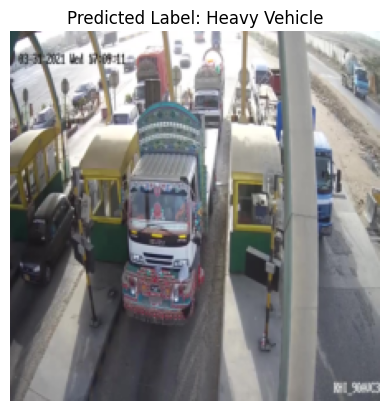

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the image
def preprocess_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image)
    return image

# Extract features using a pretrained model
def extract_features(image, model):
    with torch.no_grad():
        features = model(image.to(device))
        features = features.view(features.size(0), -1)
    return features

# Test the image with the trained model
def test_image(model, image_path, device, transform, feature_extractor):
    # Preprocess the image
    image = preprocess_image(image_path, transform)
    image = image.unsqueeze(0)  # Add batch dimension

    # Extract features
    image_features = extract_features(image, feature_extractor)

    # Predict the label
    image_features = image_features.to(device)
    with torch.no_grad():
        outputs = model(image_features)
        _, predicted = torch.max(outputs.data, 1)
    return predicted.item(), image.squeeze(0)  # Remove batch dimension for visualization

# Define transformations (adjust based on your feature extraction process)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as per your model's input
    transforms.ToTensor(),
])

# Load the feature extractor (pretrained model)
pretrained_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.to(device)
pretrained_model.eval()

# Example image path
image_path = '/content/drive/MyDrive/train/images/AVC10891.jpg'

# Predict the label for the image
predicted_label_index, image = test_image(model, image_path, device, transform, pretrained_model)
predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]

# Display the image with the predicted label
plt.imshow(image.permute(1, 2, 0).cpu())  # Convert from Tensor format to image format
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.utils import resample
from collections import Counter

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Dummy function to extract label from XML (implement this based on your XML structure)
def extract_label_from_xml(xml_path):
    # Parse XML and extract label
    # For now, return a dummy label
    # TODO: Replace with actual label extraction logic
    from random import randint # Added to create artificial label variation for testing
    return randint(0, 1) # Returns a random integer 0 or 1

# Function to load features and labels
def load_features_labels(features_dir, annotations_dir):
    features = []
    labels = []
    for feature_file in os.listdir(features_dir):
        if feature_file.endswith('.npy'):
            feature_path = os.path.join(features_dir, feature_file)
            annotation_path = os.path.join(annotations_dir, os.path.splitext(feature_file)[0] + '.xml')
            feature = np.load(feature_path, allow_pickle=True)
            label = extract_label_from_xml(annotation_path)
            features.append(feature)
            labels.append(label)
    return np.array(features), np.array(labels)

# Function to balance classes
def balance_classes(features, labels):
    label_counter = Counter(labels)
    print("Label distribution before balancing:", label_counter)

    # Separate majority and minority classes
    features_0 = features[labels == 0]
    features_1 = features[labels == 1]
    labels_0 = labels[labels == 0]
    labels_1 = labels[labels == 1]

    if len(features_0) == 0 or len(features_1) == 0:
        raise ValueError("One of the classes has no samples. Check label extraction or dataset balance.")

    # Resample minority class
    features_1_resampled, labels_1_resampled = resample(features_1, labels_1, replace=True, n_samples=len(features_0))

    # Combine resampled minority class with majority class
    features_balanced = np.concatenate([features_0, features_1_resampled])
    labels_balanced = np.concatenate([labels_0, labels_1_resampled])

    label_counter_balanced = Counter(labels_balanced)
    print("Label distribution after balancing:", label_counter_balanced)

    return features_balanced, labels_balanced

# Load feature and label data
train_features_dir = '/content/drive/MyDrive/train_features'
train_annotations_dir = '/content/drive/MyDrive/train/annotations'
train_features, train_labels = load_features_labels(train_features_dir, train_annotations_dir)

# Print label distribution before balancing
print("Initial label distribution:", Counter(train_labels))

# Balance classes
train_features_balanced, train_labels_balanced = balance_classes(train_features, train_labels)

# Create DataLoader
train_dataset = CustomDataset(train_features_balanced, train_labels_balanced)
train_loader = DataLoader(train_dataset, batch_size=32)

Initial label distribution: Counter({0: 33, 1: 29})
Label distribution before balancing: Counter({0: 33, 1: 29})
Label distribution after balancing: Counter({0: 33, 1: 33})


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from PIL import Image

# Step 1: Load Features and Labels from Directory
def load_features_from_directory(directory_path):
    feature_list = []
    label_list = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(directory_path, file_name)
            data = np.load(file_path, allow_pickle=True).item()
            features = data['features']
            label = data['label']
            feature_list.append(features)
            label_list.append(label)
    all_features = np.vstack(feature_list)
    return all_features, label_list

# Replace with your feature directory
train_feature_dir = '/content/drive/MyDrive/train_features'
test_feature_dir = '/content/drive/MyDrive/test_features'

# Load train and test features
X_train, y_train = load_features_from_directory(train_feature_dir)
X_test, y_test = load_features_from_directory(test_feature_dir)

# Step 2: Convert Labels to Numeric Values
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.transform(y_test)

# Step 3: Perform SMOTE for Class Balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_numeric)

print("Original class distribution:", Counter(y_train_numeric))
print("Balanced class distribution:", Counter(y_train_balanced))

# Step 4: Convert to PyTorch Tensors and Create DataLoader
train_features_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
train_labels_tensor = torch.tensor(y_train_balanced, dtype=torch.long)

train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_features_tensor = torch.tensor(X_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(y_test_numeric, dtype=torch.long)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 5: Define Model, Loss Function, Optimizer
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Hyperparameters
input_dim = X_train_balanced.shape[1]
output_dim = len(label_encoder.classes_)
learning_rate = 0.001

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(input_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Step 6: Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model on the test set
accuracy = evaluate_model(model, test_loader, device)
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Original class distribution: Counter({0: 33, 1: 29})
Balanced class distribution: Counter({0: 33, 1: 33})
Epoch [1/20], Loss: 0.5752
Epoch [2/20], Loss: 0.4689
Epoch [3/20], Loss: 0.0300
Epoch [4/20], Loss: 0.2876
Epoch [5/20], Loss: 0.0144
Epoch [6/20], Loss: 0.3133
Epoch [7/20], Loss: 0.2943
Epoch [8/20], Loss: 0.0159
Epoch [9/20], Loss: 0.0120
Epoch [10/20], Loss: 0.0089
Epoch [11/20], Loss: 0.3448
Epoch [12/20], Loss: 0.1799
Epoch [13/20], Loss: 0.4876
Epoch [14/20], Loss: 0.3218
Epoch [15/20], Loss: 0.0085
Epoch [16/20], Loss: 0.0075
Epoch [17/20], Loss: 0.0077
Epoch [18/20], Loss: 0.0086
Epoch [19/20], Loss: 0.4468
Epoch [20/20], Loss: 0.0080
Accuracy of the model on the test set: 87.10%
